# **Pepper Bell Disease Classification**

Dataset used: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

### **Loading the module and datas**

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [8]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 1000
FILE_PATH="230401"

In [9]:
#copying only the necessary datasets . doing only Pepper bell
#!mkdir "230401"

!cp -r "../input/crop-anthracnose/crop/anthracnose" "/kaggle/working/230401"
!cp -r "../input/crop-anthracnose/crop/healthy" "/kaggle/working/230401"


In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,64),
            batch_size = BATCH_SIZE,
)

Found 266 files belonging to 2 classes.


In [26]:
class_names = dataset.class_names
class_names

['anthracnose', 'healthy']

### **Data Visualization**

In [27]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 64, 3)
[0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1]


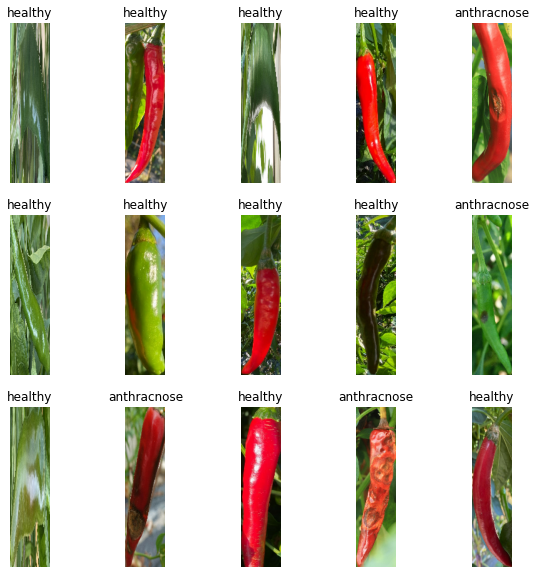

In [31]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Train Test Split**

In [59]:
def get_dataset_partitions(ds,train_split=0.8,valid_split=0.2,shuffle=True,shuffle_size=10000):
    assert  train_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    #test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,valid_ds
    

In [60]:
train_ds ,valid_ds = get_dataset_partitions(dataset)
    

In [61]:
print(len(train_ds))
#print(len(test_ds))
print(len(valid_ds))

7
1


In [62]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Image Preprocessing**

In [63]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [75]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### **Building a Model**

In [76]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [77]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_8 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (32, 60, 60, 64)         

In [43]:
#CNN 시각화
import tensorflow
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#get list of layers from model
layer_outputs = [layer.output for layer in model.layers[2:]]
print(layer_outputs)

[<KerasTensor: shape=(32, 127, 127, 32) dtype=float32 (created by layer 'max_pooling2d_12')>, <KerasTensor: shape=(32, 125, 125, 64) dtype=float32 (created by layer 'conv2d_13')>, <KerasTensor: shape=(32, 62, 62, 64) dtype=float32 (created by layer 'max_pooling2d_13')>, <KerasTensor: shape=(32, 60, 60, 64) dtype=float32 (created by layer 'conv2d_14')>, <KerasTensor: shape=(32, 30, 30, 64) dtype=float32 (created by layer 'max_pooling2d_14')>, <KerasTensor: shape=(32, 28, 28, 64) dtype=float32 (created by layer 'conv2d_15')>, <KerasTensor: shape=(32, 14, 14, 64) dtype=float32 (created by layer 'max_pooling2d_15')>, <KerasTensor: shape=(32, 12, 12, 64) dtype=float32 (created by layer 'conv2d_16')>, <KerasTensor: shape=(32, 6, 6, 64) dtype=float32 (created by layer 'max_pooling2d_16')>, <KerasTensor: shape=(32, 4, 4, 64) dtype=float32 (created by layer 'conv2d_17')>, <KerasTensor: shape=(32, 2, 2, 64) dtype=float32 (created by layer 'max_pooling2d_17')>, <KerasTensor: shape=(32, 256) dtype

In [44]:
#creat a visualization model
visualize_model = tensorflow.keras.models.Model(inputs=model.input,outputs = layer_outputs)

In [46]:
# load image for prediction 
img=load_img('/kaggle/input/crop-anthracnose/crop/anthracnose/0027_JPG_jpg.rf.b50d611251268ebc87a3f92b766f9a6d.jpg',target_size=(256,256))

In [47]:
#convert image to array
x = img_to_array(img)
x.shape

(256, 256, 3)

In [48]:
#Reshape image for passing it to prediction
x = x.reshape((1,256,256,3))
print(x.shape)
#Rescale the image
x = x/255

(1, 256, 256, 3)


In [49]:
#get all layers feature maps for image
feature_maps = visualize_model.predict(x)
print(len(feature_maps))

15


In [50]:
# Show names of laters available in model
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['sequential_4', 'conv2d_12', 'max_pooling2d_12', 'conv2d_13', 'max_pooling2d_13', 'conv2d_14', 'max_pooling2d_14', 'conv2d_15', 'max_pooling2d_15', 'conv2d_16', 'max_pooling2d_16', 'conv2d_17', 'max_pooling2d_17', 'flatten_2', 'dropout_2', 'dense_4', 'dense_5']


(1, 127, 127, 32)
(1, 125, 125, 64)
(1, 62, 62, 64)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(1, 60, 60, 64)
(1, 30, 30, 64)
(1, 28, 28, 64)
(1, 14, 14, 64)
(1, 12, 12, 64)
(1, 6, 6, 64)
(1, 4, 4, 64)
(1, 2, 2, 64)
(1, 256)
(1, 256)
(1, 64)
(1, 2)


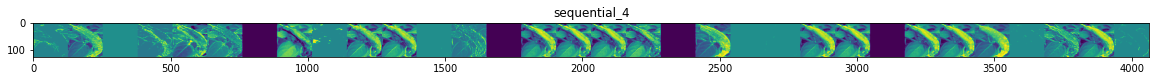

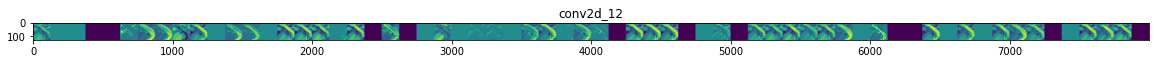

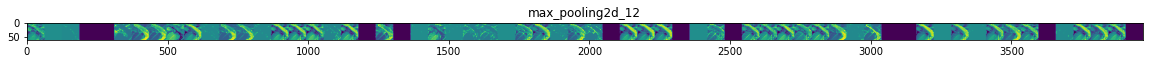

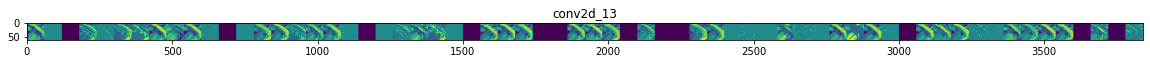

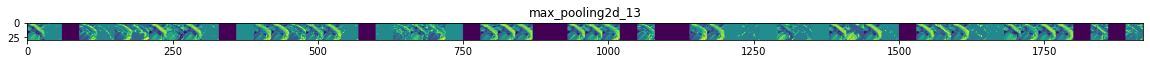

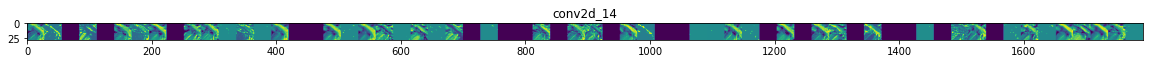

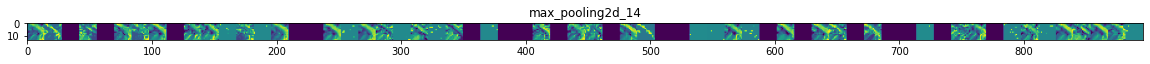

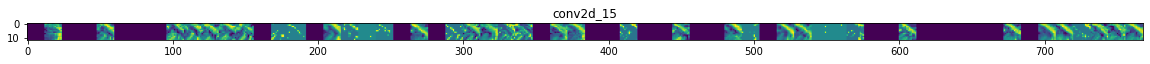

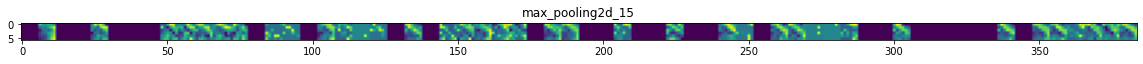

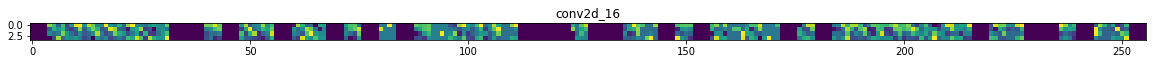

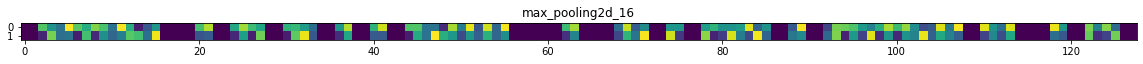

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the graph
for layer_names, feature_maps in zip(layer_names,feature_maps):
  print(feature_maps.shape)
  if len(feature_maps.shape) == 4 :
    channels = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * channels))
    for i in range(channels):
      x = feature_maps[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / channels
    plt.figure(figsize=(scale * channels, scale))
    plt.title(layer_names)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [52]:
#filters visualization
filters = model.layers[2].get_weights()
print(filters)

[]


conv2d_12
32


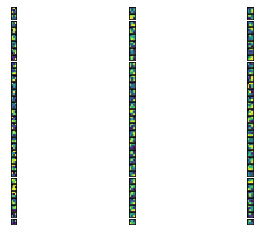

conv2d_13
64


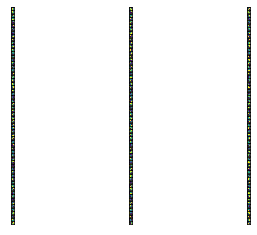

conv2d_14
64


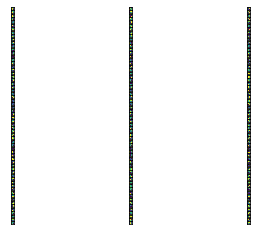

conv2d_15
64


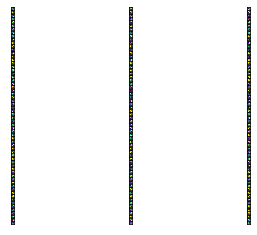

conv2d_16
64


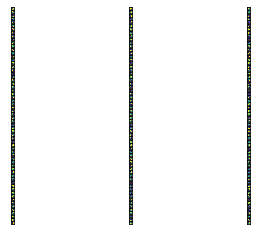

conv2d_17
64


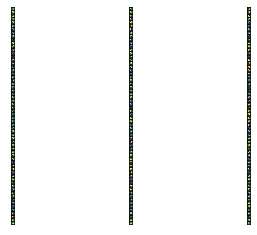

In [53]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

In [82]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [83]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5,
    min_delta=0.02
)

In [84]:
#model training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=100
    #callbacks=[callback]
    
)

Epoch 1/100
7/7 [==============================] - 2s 61ms/step - loss: 0.6843 - accuracy: 0.5580 - val_loss: 0.6739 - val_accuracy: 0.5938
Epoch 2/100
7/7 [==============================] - 0s 36ms/step - loss: 0.6466 - accuracy: 0.6250 - val_loss: 0.6400 - val_accuracy: 0.5938
Epoch 3/100
7/7 [==============================] - 0s 36ms/step - loss: 0.5948 - accuracy: 0.6205 - val_loss: 0.5950 - val_accuracy: 0.5938
Epoch 4/100
7/7 [==============================] - 0s 35ms/step - loss: 0.5589 - accuracy: 0.6205 - val_loss: 0.5567 - val_accuracy: 0.5938
Epoch 5/100
7/7 [==============================] - 0s 41ms/step - loss: 0.5169 - accuracy: 0.6205 - val_loss: 0.5281 - val_accuracy: 0.5938
Epoch 6/100
7/7 [==============================] - 0s 43ms/step - loss: 0.4910 - accuracy: 0.6205 - val_loss: 0.4998 - val_accuracy: 0.6875
Epoch 7/100
7/7 [==============================] - 0s 39ms/step - loss: 0.4891 - accuracy: 0.6875 - val_loss: 0.5257 - val_accuracy: 0.6875
Epoch 8/100
7/7 [===

In [85]:
scores = model.evaluate(test_ds)
scores

2/2 [==============================] - 0s 6ms/step - loss: 0.5039 - accuracy: 0.6429


[0.5038657188415527, 0.6428571343421936]

### **Plotting Model Accuracy**

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

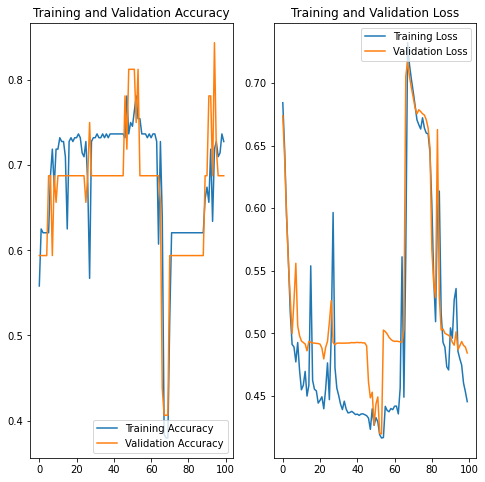

In [87]:
EPOCHS=100
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Running prediction on a sample image**

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

### **Predictions**

In [ ]:
def predict_pepper_bell_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_pepper_bell_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **Saving the Model**

In [ ]:
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/bell_pepper_{model_version}")

In [ ]:
model.save("anth_CNN.h5")

In [ ]:
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'anth_CNN.h5')

#### **THE END :)**